Arbitrage Analysis & Regression-Based Forecasting


-  Linear Regression | Predict fair value from inputs | Regression, residual analysis
- Arbitrage | Limit Order Book vs Conversion Price | Compare prices if both markets exist
- Fair Value MM | Market make near predicted value | Error vs spread analysis

We can trade macarons in our local market, and we can trade them in the international market. If we want to buy them on the international market, we need to pay the askPrice, import tariff, and transport fees. If we want to sell them on the international market, we need to pay the bidPrice, export tariff, and transport fees. An arbitrage opportunity may be possible if the price difference between the local market and the international market is greater than the sum of the import tariff, export tariff, and transport fees.


In [12]:
import pandas as pd
import os
import glob
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

In [13]:

def load_historical_data(directory_path):
    historical_data = {}
    days = [1, 2, 3]

    if not os.path.isdir(directory_path):
        print(f"Error: Directory not found: {directory_path}")
        return historical_data

    print(f"Loading historical data for Round 4 from: {directory_path}")

    for day in days:
        day_data = {}
        day_str = str(day)

        prices_pattern = os.path.join(directory_path, f'prices_round_4_day_{day_str}.csv')
        trades_pattern = os.path.join(directory_path, f'trades_round_4_day_{day_str}_nn.csv')
        observations_pattern = os.path.join(directory_path, f'observations_round_4_day_{day_str}.csv')

        price_files = glob.glob(prices_pattern)
        trade_files = glob.glob(trades_pattern)
        observations_files = glob.glob(observations_pattern)

        if price_files:
            prices_file_path = price_files[0]
            df_prices = pd.read_csv(prices_file_path, sep=';')
            df_prices['timestamp'] += (day - 1) * 1_000_000
            df_prices['day'] = day
            day_data['prices'] = df_prices

        if trade_files:
            trades_file_path = trade_files[0]
            df_trades = pd.read_csv(trades_file_path, sep=';')
            df_trades['timestamp'] += (day - 1) * 1_000_000
            df_trades['day'] = day
            day_data['trades'] = df_trades

        if observations_files:
            observations_file_path = observations_files[0]
            df_observations = pd.read_csv(observations_file_path, sep=',')
            df_observations['timestamp'] += (day - 1) * 1_000_000
            df_observations['day'] = day
            day_data['observations'] = df_observations

        if day_data:
            historical_data[day] = day_data

    return historical_data


directory_path = 'C:/Users/Admin/projects/prosperity-poj/strategy/round4/resources/round4'
historical_data = load_historical_data(directory_path)


all_prices = pd.concat([data['prices'] for data in historical_data.values() if 'prices' in data], ignore_index=True)
all_trades = pd.concat([data['trades'] for data in historical_data.values() if 'trades' in data], ignore_index=True)
all_observations = pd.concat([data['observations'] for data in historical_data.values() if 'observations' in data], ignore_index=True)


print(all_prices.head())
print(all_trades.head())
print(all_observations.head())


print("Price Columns:", all_prices.columns)
print("Trade Columns:", all_trades.columns)
print("Observation Columns:", all_observations.columns)


Loading historical data for Round 4 from: C:/Users/Admin/projects/prosperity-poj/strategy/round4/resources/round4
   day  timestamp                     product  bid_price_1  bid_volume_1  \
0    1          0               VOLCANIC_ROCK      10515.0         143.0   
1    1          0              PICNIC_BASKET1      58705.0          12.0   
2    1          0              PICNIC_BASKET2      30252.0          12.0   
3    1          0  VOLCANIC_ROCK_VOUCHER_9500       1015.0          12.0   
4    1          0  VOLCANIC_ROCK_VOUCHER_9750        766.0          12.0   

   bid_price_2  bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  \
0      10514.0          57.0          NaN           NaN        10517   
1      58704.0          27.0          NaN           NaN        58716   
2      30251.0          27.0          NaN           NaN        30258   
3          NaN           NaN          NaN           NaN         1017   
4          NaN           NaN          NaN           NaN          767 

In [14]:
#Identify arbitrage opportunities


all_prices= all_prices.merge(all_observations, on='timestamp', how='left')



all_prices = all_prices[all_prices['product'] == 'MAGNIFICENT_MACARONS'].copy() # Use .copy() to avoid SettingWithCopyWarning

# Calculate effective conversion prices
# Price to BUY from Chefs
all_prices['conversion_buy_price_effective'] = all_prices['askPrice'] + all_prices['transportFees'] + all_prices['importTariff']
# Price to SELL to Chefs 
all_prices['conversion_sell_price_effective'] = all_prices['bidPrice'] - all_prices['transportFees'] - all_prices['exportTariff']

# --- Arbitrage Scenario 1: Buy on Market, Sell to Chefs ---

all_prices['arb1_possible'] = all_prices['ask_price_1'] < all_prices['conversion_sell_price_effective']
all_prices['arb1_profit_per_unit'] = all_prices['conversion_sell_price_effective'] - all_prices['ask_price_1']

# --- Arbitrage Scenario 2: Buy from Chefs, Sell on Market ---

all_prices['arb2_possible'] = all_prices['conversion_buy_price_effective'] < all_prices['bid_price_1']
all_prices['arb2_profit_per_unit'] = all_prices['bid_price_1'] - all_prices['conversion_buy_price_effective']


arbitrage_opportunities = all_prices[
    (all_prices['arb1_possible']) | (all_prices['arb2_possible'])
].copy()


arbitrage_opportunities = arbitrage_opportunities[[
    'timestamp',
    'ask_price_1', 'bid_price_1', 
    'conversion_buy_price_effective', 'conversion_sell_price_effective',
    'arb1_possible', 'arb1_profit_per_unit',
    'arb2_possible', 'arb2_profit_per_unit'
]]

print("\nArbitrage Opportunities Found:")
if arbitrage_opportunities.empty:
    print("No arbitrage opportunities detected in the analyzed data.")
else:
    print(f"Total arbitrage instances found: {len(arbitrage_opportunities)}")
    print("\nArbitrage Scenario 1 (Buy Market, Sell Chef):")
    print(arbitrage_opportunities[arbitrage_opportunities['arb1_possible']][['timestamp', 'ask_price_1', 'conversion_sell_price_effective', 'arb1_profit_per_unit']].head())
    print(f"Count: {arbitrage_opportunities['arb1_possible'].sum()}")

    print("\nArbitrage Scenario 2 (Buy Chef, Sell Market):")
    print(arbitrage_opportunities[arbitrage_opportunities['arb2_possible']][['timestamp', 'conversion_buy_price_effective', 'bid_price_1', 'arb2_profit_per_unit']].head())
    print(f"Count: {arbitrage_opportunities['arb2_possible'].sum()}")

    print("\nOverall Data Sample (showing potential arbitrage columns):")
    print(all_prices[[
        'timestamp','ask_price_1', 'bid_price_1',
        'conversion_buy_price_effective', 'conversion_sell_price_effective',
        'arb1_possible', 'arb2_possible'
        ]].head())
    print(all_prices[[
        'timestamp','ask_price_1', 'bid_price_1',
        'conversion_buy_price_effective', 'conversion_sell_price_effective',
        'arb1_possible', 'arb2_possible'
        ]].tail())




Arbitrage Opportunities Found:
Total arbitrage instances found: 782

Arbitrage Scenario 1 (Buy Market, Sell Chef):
Empty DataFrame
Columns: [timestamp, ask_price_1, conversion_sell_price_effective, arb1_profit_per_unit]
Index: []
Count: 0

Arbitrage Scenario 2 (Buy Chef, Sell Market):
      timestamp  conversion_buy_price_effective  bid_price_1  \
311        2000                           643.5        644.0   
1505      10000                           627.0        628.0   
2795      18600                           615.0        616.0   
3381      22500                           613.0        615.0   
4243      28200                           601.0        602.0   

      arb2_profit_per_unit  
311                    0.5  
1505                   1.0  
2795                   1.0  
3381                   2.0  
4243                   1.0  
Count: 782

Overall Data Sample (showing potential arbitrage columns):
    timestamp  ask_price_1  bid_price_1  conversion_buy_price_effective  \
6       

Analysis of Market Bots

Total MAGNIFICENT_MACARONS trades: 1081

Analyzed MAGNIFICENT_MACARONS Market Trades:
      timestamp  price  quantity trade_side
80         3000  660.0         5        BUY
316       17300  614.0         2        BUY
359       19800  624.0         7        BUY
381       20900  626.0         4        BUY
403       22500  615.0         2       SELL
467       26700  601.0         7       SELL
583       34000  583.0         2       SELL
744       41700  574.0         4       SELL
782       44500  570.0         4       SELL
842       46700  584.0         7       SELL
858       47600  580.0         4       SELL
884       48300  579.0         3        BUY
891       48700  575.0         5       SELL
892       48700  575.0         2       SELL
1027      55300  589.0         7        BUY
1083      57900  603.0         4        BUY
1089      58300  600.0         5        BUY
1140      61300  606.0         4        BUY
1205      63300  596.0         7       SELL
1207      63400  601.0         7  

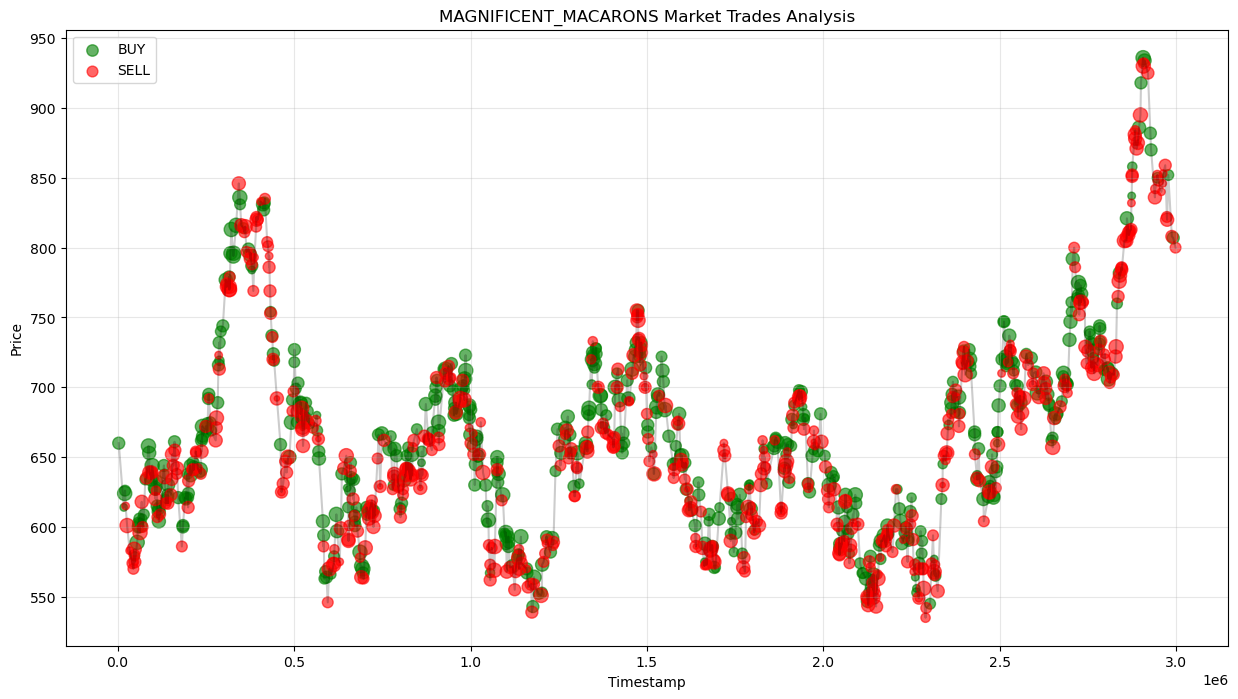


Largest Consecutive Trade Groups (same side):
                       timestamp                quantity  price         \
                           first     last count      sum    min    max   
trade_group trade_side                                                   
309         BUY          1739100  1769900     9       44  581.0  623.0   
447         BUY          2506400  2519900     8       38  715.0  747.0   
70          SELL          380700   405000     8       30  769.0  833.0   
520         SELL         2949700  2974400     7       25  820.0  859.0   
2           SELL           22500    47600     7       30  570.0  615.0   
506         SELL         2865200  2873200     7       26  809.0  832.0   
504         SELL         2840800  2859700     7       38  780.0  808.0   
429         BUY          2408800  2429000     7       36  666.0  727.0   
248         SELL         1390000  1407300     6       27  657.0  666.0   
416         SELL         2341000  2354300     6       28  648.0  

In [15]:
macaron_trades = all_trades[all_trades['symbol'] == 'MAGNIFICENT_MACARONS'].copy()
print(f"Total MAGNIFICENT_MACARONS trades: {len(macaron_trades)}")


price_lookup = all_prices[['timestamp', 'bid_price_1', 'ask_price_1']].copy()

# determine if a trade is a buy or sell based on price matching
def determine_trade_side(trade_row, price_df):
    
    trade_time = trade_row['timestamp']
    trade_price = trade_row['price']
    
    
    prev_prices = price_df[price_df['timestamp'] <= trade_time].sort_values('timestamp', ascending=False)
    
    if prev_prices.empty:
        return "UNKNOWN"
    
    closest_price = prev_prices.iloc[0]
    
    
    if abs(trade_price - float(closest_price['ask_price_1'])) < 0.1:
        return "BUY"
    
    elif abs(trade_price - float(closest_price['bid_price_1'])) < 0.1:
        return "SELL"
    else:
        
        if abs(trade_price - float(closest_price['bid_price_1'])) < abs(trade_price - float(closest_price['ask_price_1'])):
            return "SELL"  
        else:
            return "BUY"   


macaron_trades['trade_side'] = macaron_trades.apply(
    lambda row: determine_trade_side(row, price_lookup), axis=1
)


macaron_trades = macaron_trades.sort_values('timestamp')


print("\nAnalyzed MAGNIFICENT_MACARONS Market Trades:")
print(macaron_trades[['timestamp', 'price', 'quantity', 'trade_side']].head(20))

# Calculate some statistics
print("\nTrade Side Distribution:")
print(macaron_trades['trade_side'].value_counts())

print("\nAverage Trade Size by Side:")
print(macaron_trades.groupby('trade_side')['quantity'].mean())

print("\nTotal Volume by Side:")
print(macaron_trades.groupby('trade_side')['quantity'].sum())


import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))


buys = macaron_trades[macaron_trades['trade_side'] == 'BUY']
sells = macaron_trades[macaron_trades['trade_side'] == 'SELL']


plt.scatter(buys['timestamp'], buys['price'], c='green', label='BUY', s=buys['quantity']*15, alpha=0.6)
plt.scatter(sells['timestamp'], sells['price'], c='red', label='SELL', s=sells['quantity']*15, alpha=0.6)


plt.plot(macaron_trades['timestamp'], macaron_trades['price'], 'k-', alpha=0.2)

plt.title('MAGNIFICENT_MACARONS Market Trades Analysis')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


macaron_trades['side_change'] = macaron_trades['trade_side'].shift() != macaron_trades['trade_side']
macaron_trades['trade_group'] = macaron_trades['side_change'].cumsum()

trade_groups = macaron_trades.groupby(['trade_group', 'trade_side']).agg({
    'timestamp': ['first', 'last', 'count'],
    'quantity': 'sum',
    'price': ['min', 'max', 'mean']
})


largest_groups = trade_groups.sort_values([('timestamp', 'count')], ascending=False).head(10)
print("\nLargest Consecutive Trade Groups (same side):")
print(largest_groups)


macaron_trades['price_change'] = macaron_trades['price'].diff()
macaron_trades['price_pct_change'] = macaron_trades['price'].pct_change() * 100

print("\nPrice Movement Statistics:")
print(macaron_trades[['price_change', 'price_pct_change']].describe())


Predicting Macaron prices

Index(['day_x', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1',
       'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3',
       'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2',
       'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss',
       'bidPrice', 'askPrice', 'transportFees', 'exportTariff', 'importTariff',
       'sugarPrice', 'sunlightIndex', 'day_y',
       'conversion_buy_price_effective', 'conversion_sell_price_effective',
       'arb1_possible', 'arb1_profit_per_unit', 'arb2_possible',
       'arb2_profit_per_unit', 'trade_dir', 'volume', 'dir_ma_1', 'vol_ma_1',
       'dir_ma_5', 'vol_ma_5', 'dir_ma_10', 'vol_ma_10', 'dir_ma_20',
       'vol_ma_20'],
      dtype='object')
Training data mean price: 652.35
Test data mean price: 691.12
Difference: 38.78
# Feature means for MacaronsStrategy
self.feature_means = {
    "price_lag_1": 652.268519,
    "price_lag_3": 652.317460,
    "price_lag_5": 652.453042,
    "price_chg_1": 0.079365,


C:\Users\Admin\AppData\Local\Temp\ipykernel_55260\1013765878.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[trade_cols] = df[trade_cols].fillna(method='ffill').fillna(0)


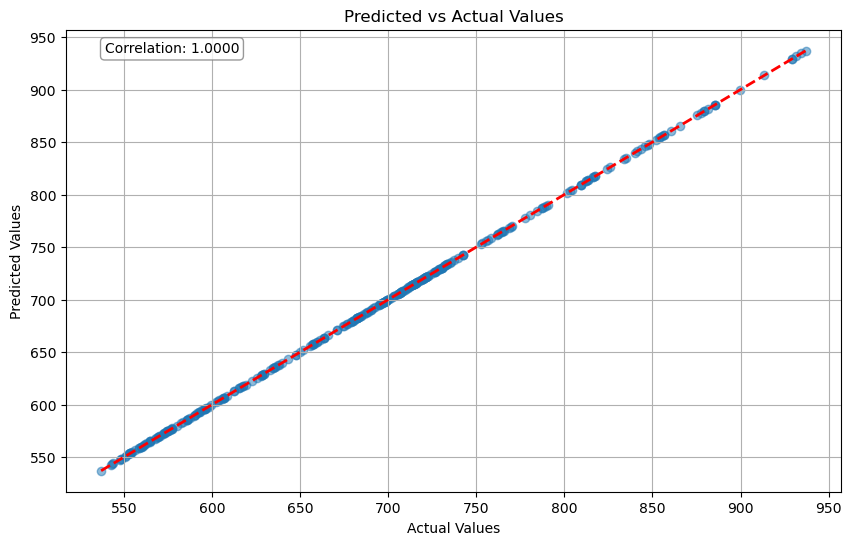

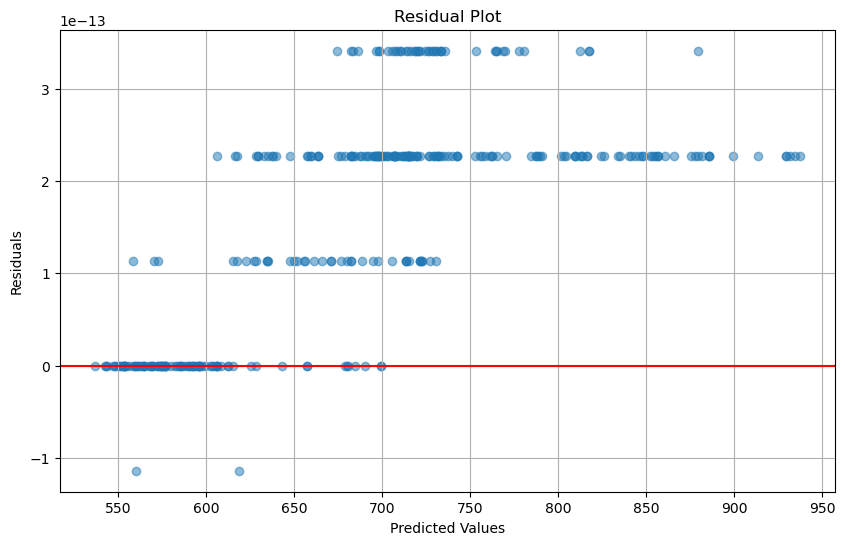

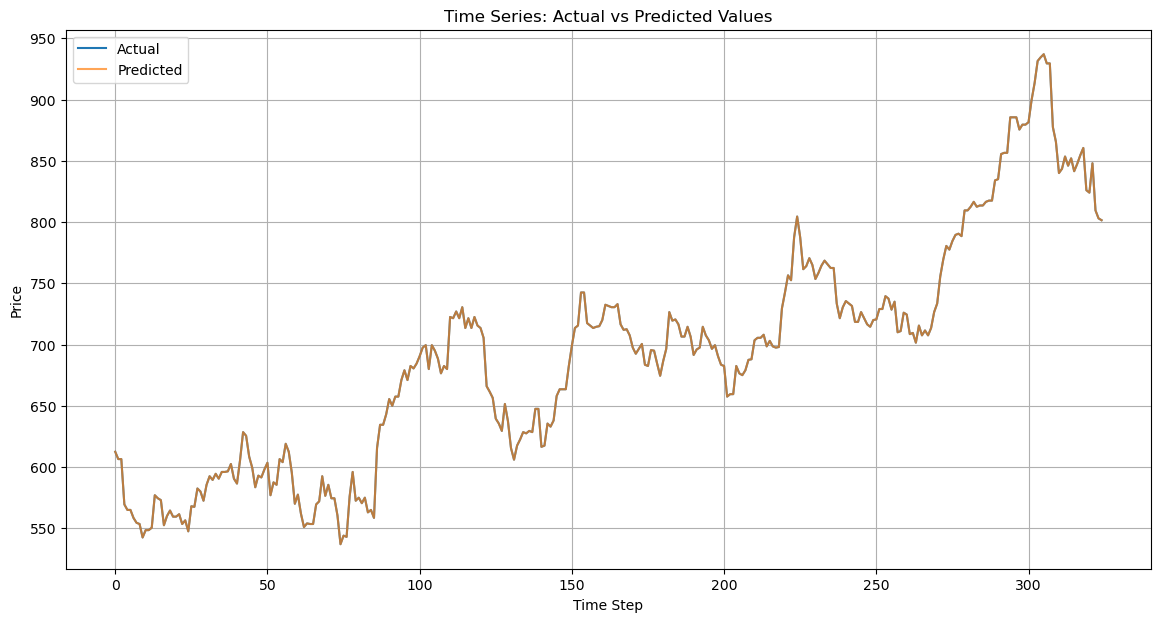


=== Feature Importance ===


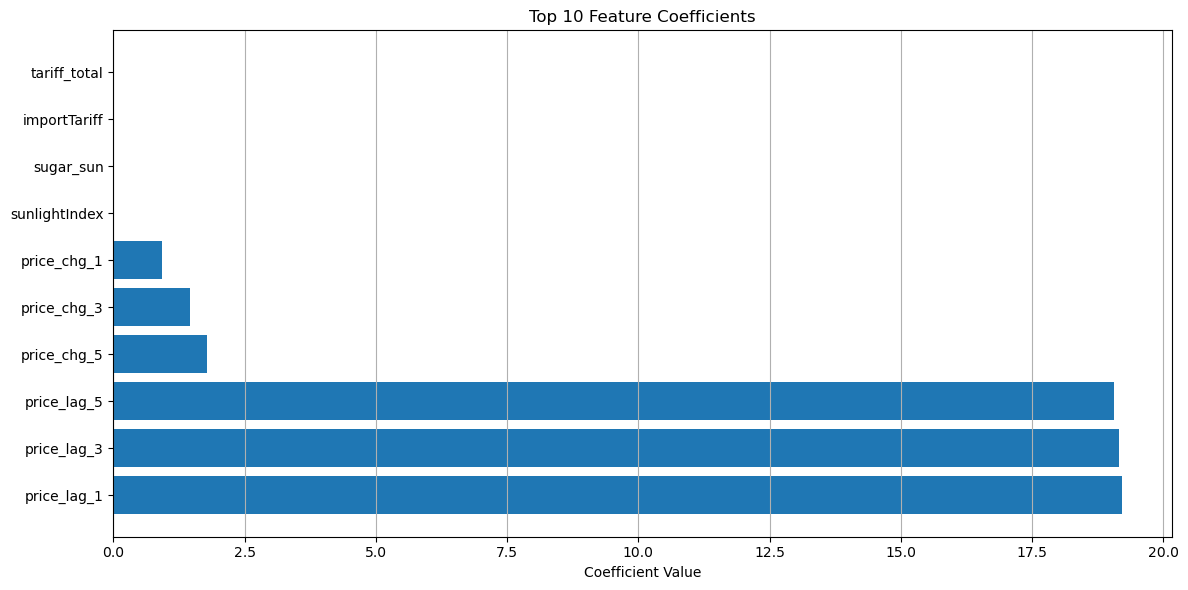


=== Model for Implementation ===
Base price (train mean): 652.347884
Intercept adjustment: -0.000000
price_lag_1: 19.204845
price_lag_3: 19.159536
price_lag_5: 19.051234
price_chg_5: 1.792625
price_chg_3: 1.450478
price_chg_1: 0.935582
sunlightIndex: 0.000000
sugar_sun: -0.000000
importTariff: 0.000000
tariff_total: -0.000000

=== Trading Algorithm Implementation ===
self.coefficients = {
    "base_price": 652.347884,
    "intercept": -0.000000,
    "price_lag_1": 19.204845,
    "price_lag_3": 19.159536,
    "price_lag_5": 19.051234,
    "price_chg_5": 1.792625,
    "price_chg_3": 1.450478,
    "price_chg_1": 0.935582,
    "sunlightIndex": 0.000000,
    "sugar_sun": -0.000000,
    "importTariff": 0.000000,
    "tariff_total": -0.000000,
}

# Feature scaling parameters for implementation
self.feature_means = {
    "price_lag_1": 652.268519,
    "price_lag_3": 652.317460,
    "price_lag_5": 652.453042,
    "price_chg_5": -0.105159,
    "price_chg_3": 0.030423,
    "price_chg_1": 0.07936

In [20]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import matplotlib.pyplot as plt

# Filter data for macarons (assuming all_prices and all_observations are already loaded)
macaron_data = all_prices[all_prices['product'] == 'MAGNIFICENT_MACARONS'].copy()
macaron_trades = all_trades[all_trades['symbol'] == 'MAGNIFICENT_MACARONS'].copy()

# Determine trade direction
def get_trade_side(row, prices):
    time = row['timestamp']
    price = row['price']
    prev = prices[prices['timestamp'] <= time].sort_values('timestamp', ascending=False)
    if prev.empty:
        return 0
    closest = prev.iloc[0]
    if abs(price - float(closest['ask_price_1'])) < abs(price - float(closest['bid_price_1'])):
        return 1  # buy
    else:
        return -1  # sell

macaron_trades['trade_dir'] = macaron_trades.apply(lambda r: get_trade_side(r, macaron_data), axis=1)
macaron_trades = macaron_trades.sort_values('timestamp')

# Create trade features dataframe
trade_features = pd.DataFrame()
trade_features['timestamp'] = macaron_trades['timestamp']
trade_features['trade_dir'] = macaron_trades['trade_dir']
trade_features['volume'] = macaron_trades['quantity']

# Calculate rolling features
for w in [1, 5, 10, 20]:
    trade_features[f'dir_ma_{w}'] = trade_features['trade_dir'].rolling(w).mean().fillna(0)
    trade_features[f'vol_ma_{w}'] = trade_features['volume'].rolling(w).mean().fillna(0)

# Merge all data
df = macaron_data
df = df.merge(trade_features, on='timestamp', how='left')

print(df.columns)

# Fill missing values
trade_cols = [c for c in df.columns if c.startswith('dir_ma_') or c.startswith('vol_ma_')]
df[trade_cols] = df[trade_cols].fillna(method='ffill').fillna(0)

# Feature engineering
df['spread'] = df['ask_price_1'] - df['bid_price_1']
df['mid_price'] = (df['ask_price_1'] + df['bid_price_1']) / 2
df['tariff_total'] = abs(df['importTariff']) + abs(df['exportTariff'])
df['sugar_sun'] = df['sugarPrice'] * df['sunlightIndex']

# Lag features - using absolute change instead of percentage for price
for lag in [1, 3, 5]:
    df[f'price_lag_{lag}'] = df['mid_price'].shift(lag)
    df[f'price_chg_{lag}'] = df['mid_price'] - df['mid_price'].shift(lag)  # Absolute change
    df[f'sunlight_chg_{lag}'] = df['sunlightIndex'].pct_change(lag)
    df[f'sugar_chg_{lag}'] = df['sugarPrice'].pct_change(lag)

df = df.dropna()

# Define features and target
features = [
    'sugarPrice', 'sunlightIndex', 'transportFees', 'exportTariff', 'importTariff',
    'dir_ma_5', 'dir_ma_10', 'vol_ma_5', 'spread', 'tariff_total', 'sugar_sun', 
    'price_chg_1', 'sunlight_chg_1', 'sunlight_chg_3', 'sunlight_chg_5', 'price_chg_3', 
    'price_chg_5', 'sugar_chg_1', 'sugar_chg_3', 'sugar_chg_5', 'price_lag_1', 
    'price_lag_3', 'price_lag_5', 'dir_ma_1'
]

X = df[features]
y = df['mid_price']

# Train/test split by time (70% train, 30% test)
split_idx = int(len(df) * 0.7)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Calculate train and test means to check for distribution shift
train_mean = y_train.mean()
test_mean = y_test.mean()
print(f"Training data mean price: {train_mean:.2f}")
print(f"Test data mean price: {test_mean:.2f}")
print(f"Difference: {abs(train_mean - test_mean):.2f}")

# Center target using ONLY training data mean
y_train_centered = y_train - train_mean
y_test_centered = y_test - train_mean  # Use training mean for test data too

#feature normalization parameters
# Calculate means and standard deviations for the specific features from training data only
target_features = ['price_lag_1', 'price_lag_3', 'price_lag_5', 'price_chg_1', 'price_chg_3', 'price_chg_5']

feature_means = {feature: X_train[feature].mean() for feature in target_features}
feature_stds = {feature: X_train[feature].std() for feature in target_features}

# Print the results in a format ready to copy into your code
print("# Feature means for MacaronsStrategy")
print("self.feature_means = {")
for feature, mean in feature_means.items():
    print(f"    \"{feature}\": {mean:.6f},")
print("}")

print("\n# Feature standard deviations for MacaronsStrategy")
print("self.feature_stds = {")
for feature, std in feature_stds.items():
    print(f"    \"{feature}\": {std:.6f},")
print("}")

# Print summary statistics for verification
print("\n# Summary statistics for verification:")
for feature in target_features:
    print(f"{feature}:")
    print(f"  Mean: {X_train[feature].mean():.6f}")
    print(f"  Std: {X_train[feature].std():.6f}")
    print(f"  Min: {X_train[feature].min():.6f}")
    print(f"  Max: {X_train[feature].max():.6f}")



# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Set up time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Test multiple models with different hyperparameters
models = {
    'Linear Regression': LinearRegression(),
    'Ridge (alpha=0.1)': Ridge(alpha=0.1),
    'Ridge (alpha=1.0)': Ridge(alpha=1.0),
    'Ridge (alpha=10.0)': Ridge(alpha=10.0),
    'Lasso (alpha=0.001)': Lasso(alpha=0.001),
    'Lasso (alpha=0.01)': Lasso(alpha=0.01),
    'Lasso (alpha=0.1)': Lasso(alpha=0.1)
}

# Perform cross-validation on centered target
print("\n=== Cross-Validation Results ===")
results = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train_centered, 
                               cv=tscv, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-cv_scores.mean())
    results[name] = {'cv_rmse': rmse, 'model': model}
    print(f"{name} - CV RMSE: {rmse:.4f}")

# Find best model
best_model_name = min(results, key=lambda m: results[m]['cv_rmse'])
best_model = results[best_model_name]['model']
print(f"\nBest model: {best_model_name} with CV RMSE: {results[best_model_name]['cv_rmse']:.4f}")

# Train final model on full training set with centered target
best_model.fit(X_train_scaled, y_train_centered)

# Evaluate on test set
y_pred_centered = best_model.predict(X_test_scaled)
# Add back the training mean to get actual predictions
y_pred = y_pred_centered + train_mean

# Calculate final metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
print(f"\nTest set RMSE: {test_rmse:.4f}")
print(f"Test set MAE: {test_mae:.4f}")
print(f"Test set R²: {test_r2:.4f}")

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.grid(True)

# Calculate and display the correlation
correlation = np.corrcoef(y_test, y_pred)[0, 1]
plt.annotate(f'Correlation: {correlation:.4f}', 
             xy=(0.05, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.show()

# Add a residual plot
plt.figure(figsize=(10, 6))
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

# Time series plot of actual vs predicted
plt.figure(figsize=(14, 7))
plt.plot(range(len(y_test)), y_test.values, label='Actual')
plt.plot(range(len(y_pred)), y_pred, label='Predicted', alpha=0.7)
plt.title('Time Series: Actual vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Extract and print coefficients
coefs = pd.DataFrame({
    'feature': features,
    'coefficient': best_model.coef_,
    'abs_value': np.abs(best_model.coef_)
}).sort_values('abs_value', ascending=False)

print("\n=== Feature Importance ===")
top_features = coefs.head(10)
plt.figure(figsize=(12, 6))
plt.barh(top_features['feature'], top_features['coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Feature Coefficients')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

print("\n=== Model for Implementation ===")
print(f"Base price (train mean): {train_mean:.6f}")
print(f"Intercept adjustment: {best_model.intercept_:.6f}")
for i, row in coefs.head(10).iterrows():
    print(f"{row['feature']}: {row['coefficient']:.6f}")

# How to use in the trading algorithm
print("\n=== Trading Algorithm Implementation ===")
print("self.coefficients = {")
print(f"    \"base_price\": {train_mean:.6f},")
print(f"    \"intercept\": {best_model.intercept_:.6f},")
for i, row in coefs.head(10).iterrows():
    print(f"    \"{row['feature']}\": {row['coefficient']:.6f},")
print("}")

print("\n# Feature scaling parameters for implementation")
feature_means = X_train.mean()
feature_stds = X_train.std()
print("self.feature_means = {")
for feature in coefs.head(10)['feature']:
    print(f"    \"{feature}\": {feature_means[feature]:.6f},")
print("}")
print("self.feature_stds = {")
for feature in coefs.head(10)['feature']:
    print(f"    \"{feature}\": {feature_stds[feature]:.6f},")
print("}")

print("\n# In prediction function:")
print("def predict_price(self, features_dict):")
print("    # First standardize the input features")
print("    standardized_features = {}")
print("    for feature, value in features_dict.items():")
print("        if feature in self.feature_means and feature in self.feature_stds:")
print("            standardized_features[feature] = (value - self.feature_means[feature]) / self.feature_stds[feature]")
print("    ")
print("    # Calculate prediction")
print("    prediction = self.coefficients['base_price'] + self.coefficients['intercept']")
print("    for feature, value in standardized_features.items():")
print("        if feature in self.coefficients:")
print("            prediction += self.coefficients[feature] * value")
print("    return prediction")

Fuck LR, lets move on to analysing the hint.

## Hint - Algo

It was well understood lore in Archipelago that low sunlight index can impact sugar and MACARON production negatively causing prices to rise due to panic among residents. However, ArchiResearchers have identified existence of a CriticalSunlightIndex (CSI).

If sunlightIndex goes below this CSI with an anticipation to remain under this critical level for a long period of time, sugar and MACARON prices can increase by substantial amount with a strong correlation.

When sunlightIndex is above this CSI, Sugar and MACARON prices tend to trade around their respective fair values and demonstrates market supply-demand dynamics.

Can you find this CSI and use it to trade better than ever and make your island prosper? All the best!

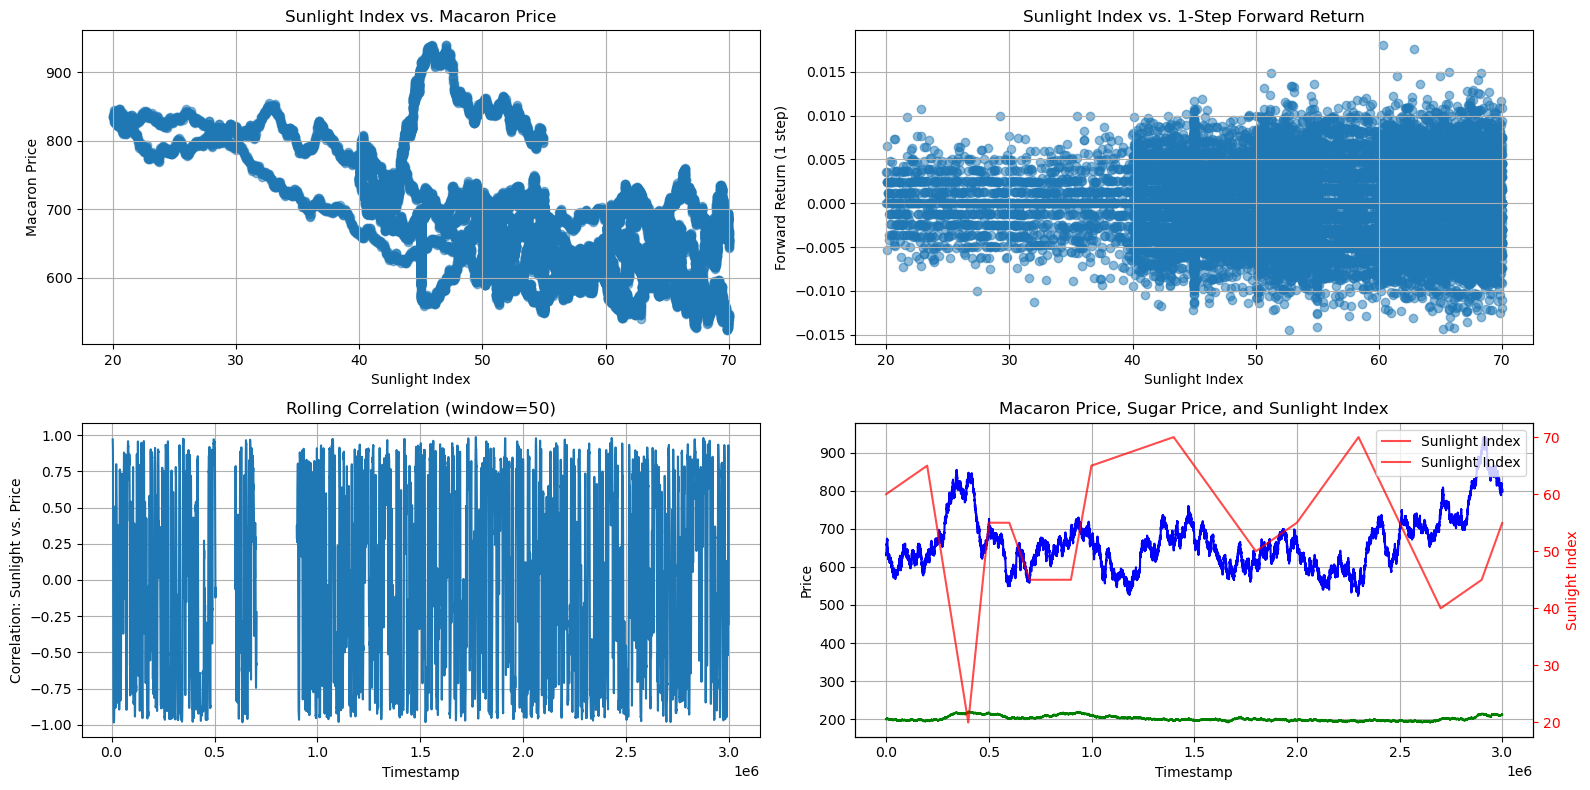

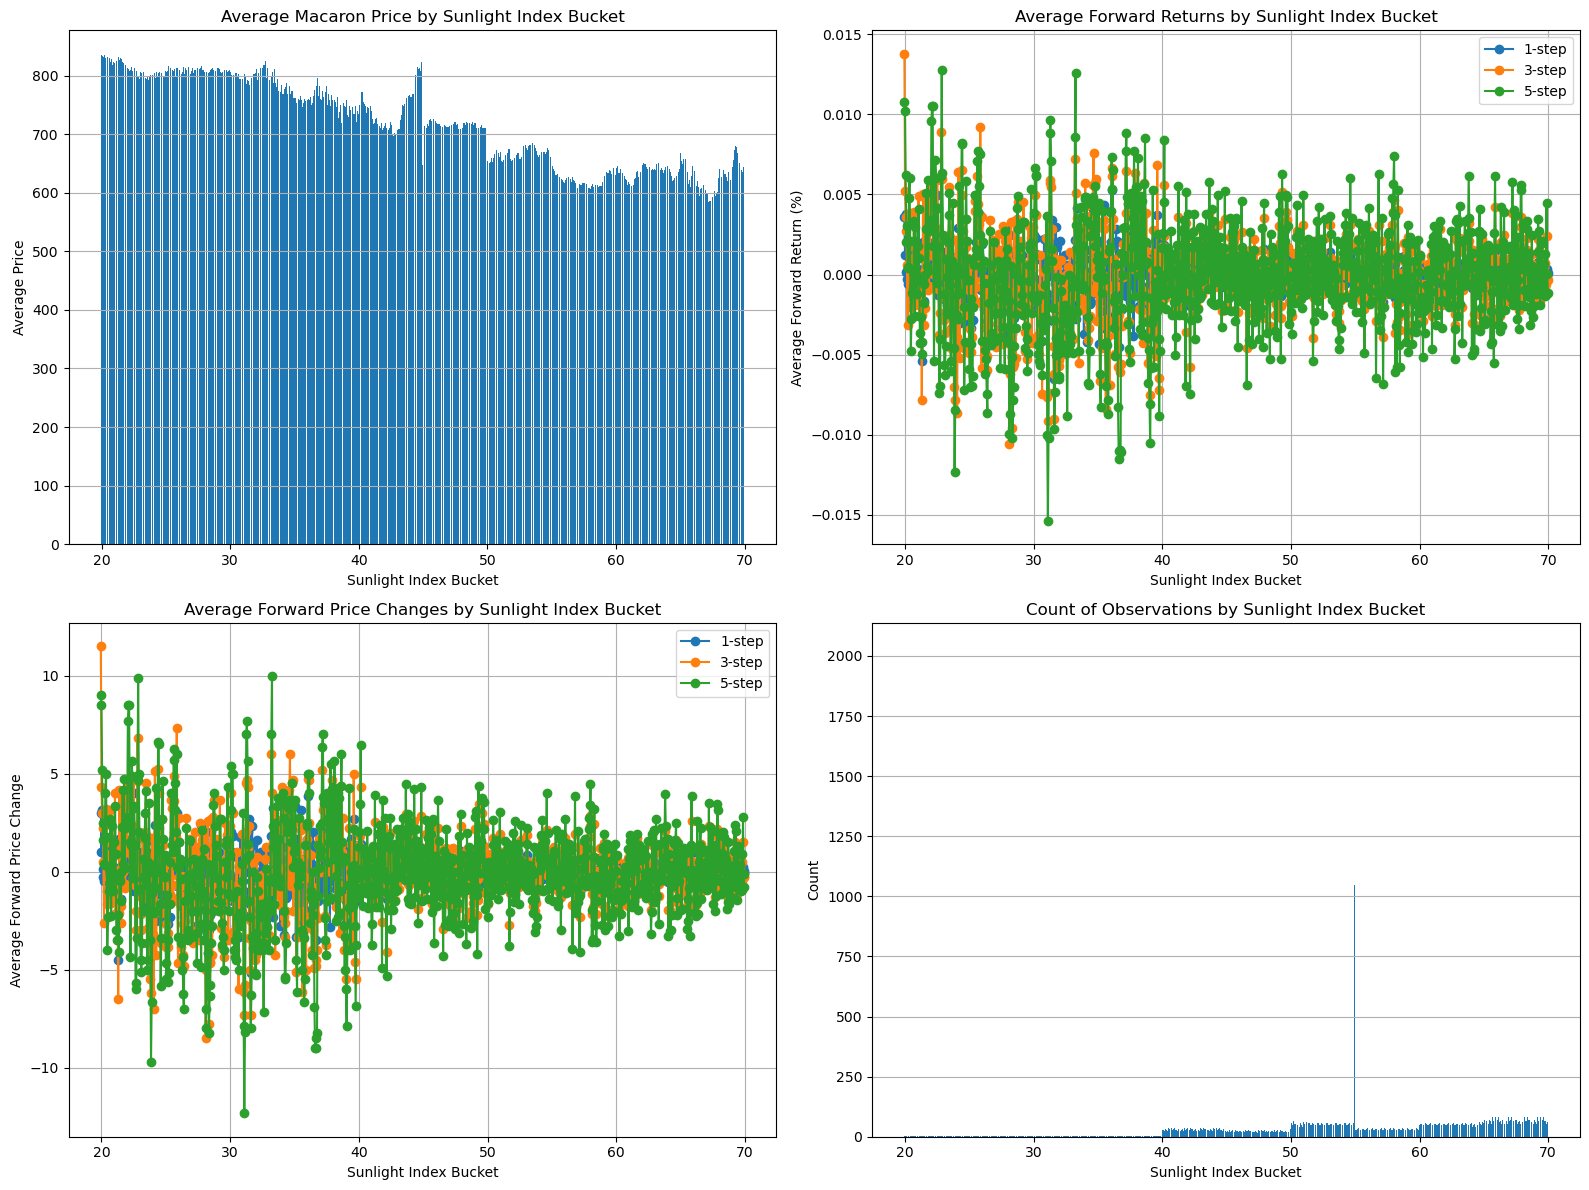

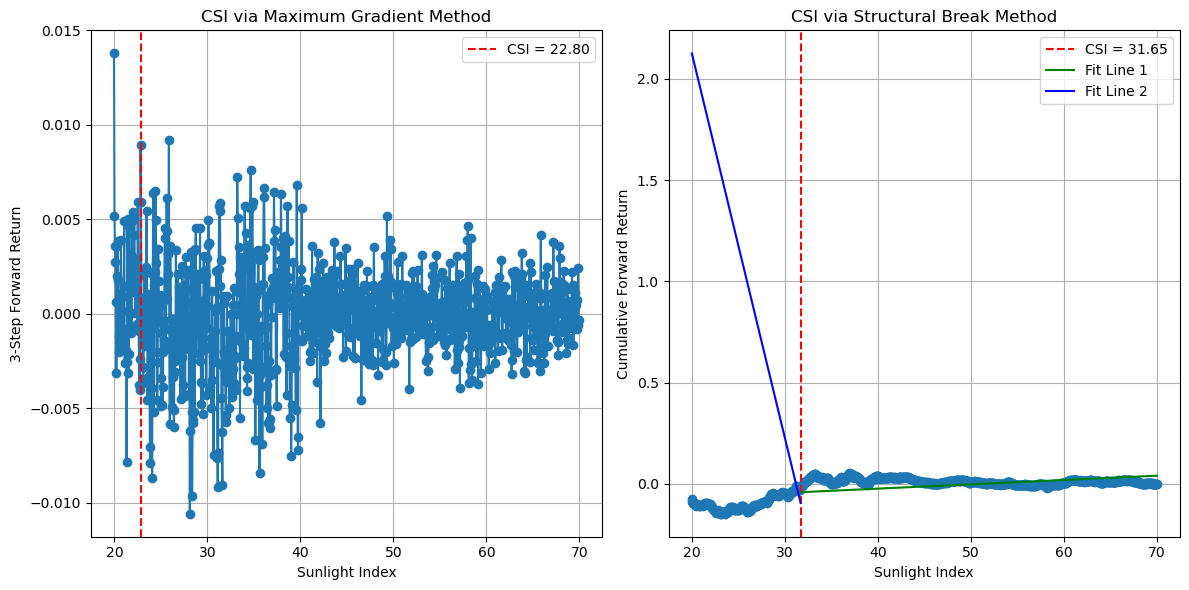

Method 1 - Gradient-based CSI: 22.800
Method 2 - Structural break CSI: 31.650


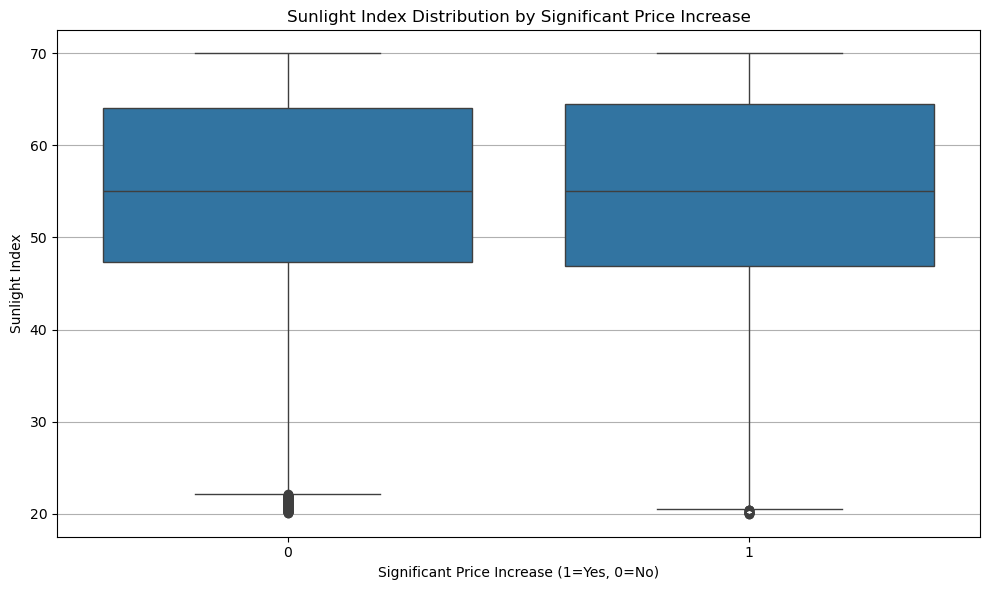


Returns statistics when below CSI:
count    204.000000
mean       0.000859
std        0.004997
min       -0.013269
25%       -0.002433
50%        0.000000
75%        0.004843
max        0.013789
Name: forward_return_3, dtype: float64

Returns statistics when above CSI:
count    29790.000000
mean         0.000040
std          0.006606
min         -0.025830
25%         -0.004494
50%          0.000000
75%          0.004528
max          0.032407
Name: forward_return_3, dtype: float64

Suggested code for implementing CSI in trading strategy:

# Add to MacaronsStrategy class
self.csi = 22.800  # Critical Sunlight Index

# In predict_next_price or act method:
def predict_next_price(self, state: TradingState) -> Optional[float]:
    # Your existing prediction code...
    
    # Adjust prediction based on CSI
    if 'sunlightIndex' in state.observations.plainValueObservations:
        sunlight_index = state.observations.plainValueObservations['sunlightIndex']
        if sunlight_index < self.c

In [24]:

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming all_prices and all_observations are already loaded

# 1. Data Preparation
# Filter data for macarons
macaron_data = all_prices[all_prices['product'] == 'MAGNIFICENT_MACARONS'].copy()

# Ensure data is sorted by timestamp
macaron_data = macaron_data.sort_values('timestamp')

# Calculate mid price and returns
macaron_data['mid_price'] = (macaron_data['ask_price_1'] + macaron_data['bid_price_1']) / 2
macaron_data['price_return'] = macaron_data['mid_price'].pct_change()
macaron_data['price_change'] = macaron_data['mid_price'].diff()

# Forward returns (will help identify predictive power)
for n in [1, 3, 5]:
    macaron_data[f'forward_return_{n}'] = macaron_data['mid_price'].shift(-n) / macaron_data['mid_price'] - 1
    macaron_data[f'forward_change_{n}'] = macaron_data['mid_price'].shift(-n) - macaron_data['mid_price']

# Clean data
macaron_data = macaron_data.dropna()

# 2. Initial Visualization
plt.figure(figsize=(16, 8))

# Scatter plot of sunlightIndex vs. macaron price
plt.subplot(2, 2, 1)
plt.scatter(macaron_data['sunlightIndex'], macaron_data['mid_price'], alpha=0.5)
plt.title('Sunlight Index vs. Macaron Price')
plt.xlabel('Sunlight Index')
plt.ylabel('Macaron Price')
plt.grid(True)

# Scatter plot of sunlightIndex vs. forward returns
plt.subplot(2, 2, 2)
plt.scatter(macaron_data['sunlightIndex'], macaron_data['forward_return_1'], alpha=0.5)
plt.title('Sunlight Index vs. 1-Step Forward Return')
plt.xlabel('Sunlight Index')
plt.ylabel('Forward Return (1 step)')
plt.grid(True)

# 3. Rolling Correlation
window_size = 50
macaron_data['rolling_corr'] = macaron_data['sunlightIndex'].rolling(window_size).corr(macaron_data['mid_price'])

plt.subplot(2, 2, 3)
plt.plot(macaron_data['timestamp'], macaron_data['rolling_corr'])
plt.title(f'Rolling Correlation (window={window_size})')
plt.xlabel('Timestamp')
plt.ylabel('Correlation: Sunlight vs. Price')
plt.grid(True)

# 4. Plot Actual and Sugar Prices with Sunlight Index on secondary y-axis
plt.subplot(2, 2, 4)
# Plot prices on primary y-axis
plt.plot(macaron_data['timestamp'], macaron_data['mid_price'], 'b-', label='Macaron Price')
plt.plot(macaron_data['timestamp'], macaron_data['sugarPrice'], 'g-', label='Sugar Price')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.grid(True)

# Create secondary y-axis for sunlight index
ax2 = plt.gca().twinx()
ax2.plot(macaron_data['timestamp'], macaron_data['sunlightIndex'], 'r-', label='Sunlight Index', alpha=0.7)
ax2.set_ylabel('Sunlight Index', color='r')
ax2.tick_params(axis='y', colors='r')

# Combine legends from both axes
lines1, labels1 = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Macaron Price, Sugar Price, and Sunlight Index')

plt.tight_layout()
plt.show()

# 5. Group by Sunlight Index Buckets
# Create buckets of sunlight index
bucket_size = 0.05
macaron_data['sunlight_bucket'] = (macaron_data['sunlightIndex'] // bucket_size) * bucket_size

# Group by buckets and calculate average forward returns/changes
sunlight_analysis = macaron_data.groupby('sunlight_bucket').agg({
    'mid_price': 'mean',
    'sugarPrice': 'mean',
    'forward_return_1': 'mean',
    'forward_return_3': 'mean',
    'forward_return_5': 'mean',
    'forward_change_1': 'mean',
    'forward_change_3': 'mean',
    'forward_change_5': 'mean',
    'sunlightIndex': 'count'  # Count of observations in each bucket
}).reset_index()

# Sort by sunlight bucket for better visualization
sunlight_analysis = sunlight_analysis.sort_values('sunlight_bucket')

# 6. Visualize Bucket Analysis
plt.figure(figsize=(16, 12))

# Average price by sunlight bucket
plt.subplot(2, 2, 1)
plt.bar(sunlight_analysis['sunlight_bucket'], sunlight_analysis['mid_price'], width=bucket_size*0.8)
plt.title('Average Macaron Price by Sunlight Index Bucket')
plt.xlabel('Sunlight Index Bucket')
plt.ylabel('Average Price')
plt.grid(True, axis='y')

# Forward returns by sunlight bucket
plt.subplot(2, 2, 2)
plt.plot(sunlight_analysis['sunlight_bucket'], sunlight_analysis['forward_return_1'], 'o-', label='1-step')
plt.plot(sunlight_analysis['sunlight_bucket'], sunlight_analysis['forward_return_3'], 'o-', label='3-step')
plt.plot(sunlight_analysis['sunlight_bucket'], sunlight_analysis['forward_return_5'], 'o-', label='5-step')
plt.title('Average Forward Returns by Sunlight Index Bucket')
plt.xlabel('Sunlight Index Bucket')
plt.ylabel('Average Forward Return (%)')
plt.legend()
plt.grid(True)

# Forward price changes by sunlight bucket
plt.subplot(2, 2, 3)
plt.plot(sunlight_analysis['sunlight_bucket'], sunlight_analysis['forward_change_1'], 'o-', label='1-step')
plt.plot(sunlight_analysis['sunlight_bucket'], sunlight_analysis['forward_change_3'], 'o-', label='3-step')
plt.plot(sunlight_analysis['sunlight_bucket'], sunlight_analysis['forward_change_5'], 'o-', label='5-step')
plt.title('Average Forward Price Changes by Sunlight Index Bucket')
plt.xlabel('Sunlight Index Bucket')
plt.ylabel('Average Forward Price Change')
plt.legend()
plt.grid(True)

# Count of observations by sunlight bucket
plt.subplot(2, 2, 4)
plt.bar(sunlight_analysis['sunlight_bucket'], sunlight_analysis['sunlightIndex'], width=bucket_size*0.8)
plt.title('Count of Observations by Sunlight Index Bucket')
plt.xlabel('Sunlight Index Bucket')
plt.ylabel('Count')
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

# 7. Find the CSI (Critical Sunlight Index)
# Look for the "elbow" point in forward returns or price change

# Method 1: Find the bucket with the highest absolute gradient in forward returns
sunlight_analysis['return_gradient'] = sunlight_analysis['forward_return_3'].diff() / bucket_size
critical_bucket_idx = sunlight_analysis['return_gradient'].abs().idxmax()
csi_method1 = sunlight_analysis.loc[critical_bucket_idx, 'sunlight_bucket']

# Method 2: Use a more sophisticated approach - look for structural breaks
# Calculate the cumulative sum of forward returns as sunlight decreases
sorted_analysis = sunlight_analysis.sort_values('sunlight_bucket', ascending=False).reset_index(drop=True)
sorted_analysis['cumulative_return'] = sorted_analysis['forward_return_3'].cumsum()

# Fit two lines to find the optimal breakpoint
best_score = float('inf')
best_breakpoint = None

for i in range(2, len(sorted_analysis) - 2):
    # Fit line to data before breakpoint
    x1 = np.arange(i)
    y1 = sorted_analysis.loc[:i-1, 'cumulative_return'].values
    slope1, intercept1, _, _, _ = stats.linregress(x1, y1)
    
    # Fit line to data after breakpoint
    x2 = np.arange(i, len(sorted_analysis))
    y2 = sorted_analysis.loc[i:, 'cumulative_return'].values
    if len(x2) > 1 and len(y2) > 1:  # Need at least 2 points for regression
        slope2, intercept2, _, _, _ = stats.linregress(x2 - i, y2)
        
        # Calculate error
        pred1 = intercept1 + slope1 * x1
        pred2 = intercept2 + slope2 * (x2 - i)
        error = np.sum((y1 - pred1)**2) + np.sum((y2 - pred2)**2)
        
        if error < best_score:
            best_score = error
            best_breakpoint = i

# Get the CSI from the best breakpoint
if best_breakpoint is not None:
    csi_method2 = sorted_analysis.loc[best_breakpoint, 'sunlight_bucket']
else:
    csi_method2 = None

# 8. Visualize the CSI
plt.figure(figsize=(12, 6))

# Method 1 result: Highest gradient
plt.subplot(1, 2, 1)
plt.plot(sunlight_analysis['sunlight_bucket'], sunlight_analysis['forward_return_3'], 'o-')
plt.axvline(x=csi_method1, color='r', linestyle='--', label=f'CSI = {csi_method1:.2f}')
plt.title('CSI via Maximum Gradient Method')
plt.xlabel('Sunlight Index')
plt.ylabel('3-Step Forward Return')
plt.legend()
plt.grid(True)

# Method 2 result: Structural break
if csi_method2 is not None:
    plt.subplot(1, 2, 2)
    plt.plot(sorted_analysis['sunlight_bucket'], sorted_analysis['cumulative_return'], 'o-')
    csi_x_index = sorted_analysis.index[sorted_analysis['sunlight_bucket'] == csi_method2].tolist()[0]
    plt.axvline(x=csi_method2, color='r', linestyle='--', label=f'CSI = {csi_method2:.2f}')
    
    # Plot the two fitted lines
    x1 = np.arange(best_breakpoint)
    y1 = intercept1 + slope1 * x1
    plt.plot(sorted_analysis.loc[:best_breakpoint-1, 'sunlight_bucket'], y1, 'g-', label='Fit Line 1')
    
    x2 = np.arange(best_breakpoint, len(sorted_analysis))
    y2 = intercept2 + slope2 * (x2 - best_breakpoint)
    plt.plot(sorted_analysis.loc[best_breakpoint:, 'sunlight_bucket'], y2, 'b-', label='Fit Line 2')
    
    plt.title('CSI via Structural Break Method')
    plt.xlabel('Sunlight Index')
    plt.ylabel('Cumulative Forward Return')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# 9. Print out findings
print(f"Method 1 - Gradient-based CSI: {csi_method1:.3f}")
if csi_method2 is not None:
    print(f"Method 2 - Structural break CSI: {csi_method2:.3f}")

# 10. Validate findings with a classification approach
# Create a binary variable for whether the price increased significantly
significant_threshold = macaron_data['forward_change_3'].std() * 0.5
macaron_data['significant_increase'] = (macaron_data['forward_change_3'] > significant_threshold).astype(int)

# See how this binary outcome relates to the sunlight index
plt.figure(figsize=(10, 6))
sns.boxplot(x='significant_increase', y='sunlightIndex', data=macaron_data)
plt.title('Sunlight Index Distribution by Significant Price Increase')
plt.xlabel('Significant Price Increase (1=Yes, 0=No)')
plt.ylabel('Sunlight Index')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Calculate average return when below vs. above the CSI
csi = csi_method1  # Use method 1 result
macaron_data['below_csi'] = (macaron_data['sunlightIndex'] < csi).astype(int)

# Group statistics
below_csi_stats = macaron_data[macaron_data['below_csi'] == 1]['forward_return_3'].describe()
above_csi_stats = macaron_data[macaron_data['below_csi'] == 0]['forward_return_3'].describe()

print("\nReturns statistics when below CSI:")
print(below_csi_stats)
print("\nReturns statistics when above CSI:")
print(above_csi_stats)

# Implement the CSI into trading strategy
print("\nSuggested code for implementing CSI in trading strategy:")
print(f"""
# Add to MacaronsStrategy class
self.csi = {csi:.3f}  # Critical Sunlight Index

# In predict_next_price or act method:
def predict_next_price(self, state: TradingState) -> Optional[float]:
    # Your existing prediction code...
    
    # Adjust prediction based on CSI
    if 'sunlightIndex' in state.observations.plainValueObservations:
        sunlight_index = state.observations.plainValueObservations['sunlightIndex']
        if sunlight_index < self.csi:
            # Stronger upward bias when below CSI
            prediction_adjustment = 5.0  # Adjust this value based on your analysis
            prediction += prediction_adjustment
            logger.print(f"T={{state.timestamp}}: Below CSI {{self.csi}}, adjusting prediction by +{{prediction_adjustment}}")
    
    return prediction
""")

# Output price movement statistics for various sunlight index ranges
print("\nPrice movement statistics by sunlight index range:")
for lower in np.arange(0.3, 0.7, 0.05):
    upper = lower + 0.05
    filtered_data = macaron_data[(macaron_data['sunlightIndex'] >= lower) & 
                                (macaron_data['sunlightIndex'] < upper)]
    if len(filtered_data) > 0:
        avg_return = filtered_data['forward_return_3'].mean() * 100
        print(f"Sunlight {lower:.2f}-{upper:.2f}: Avg 3-step return = {avg_return:.2f}%, n={len(filtered_data)}")


Data ranges:
sunlightIndex: 20.0 to 70.0
mid_price: 523.5 to 940.5
forward_return_3: -0.02583025830258301 to 0.03240740740740744

Slope statistics:
count    29992.000000
mean        -0.000169
std          0.011181
min         -0.030000
25%         -0.010000
50%          0.000000
75%          0.000000
max          0.040000
Name: sunlight_slope, dtype: float64

Using slope change threshold: 0.007634957153815643

Data points after cleaning: 29992

Plot 1 ranges - X: -0.03000000000000469 to 0.04000000000000625
Plot 1 ranges - Y: -0.02583025830258301 to 0.03240740740740744


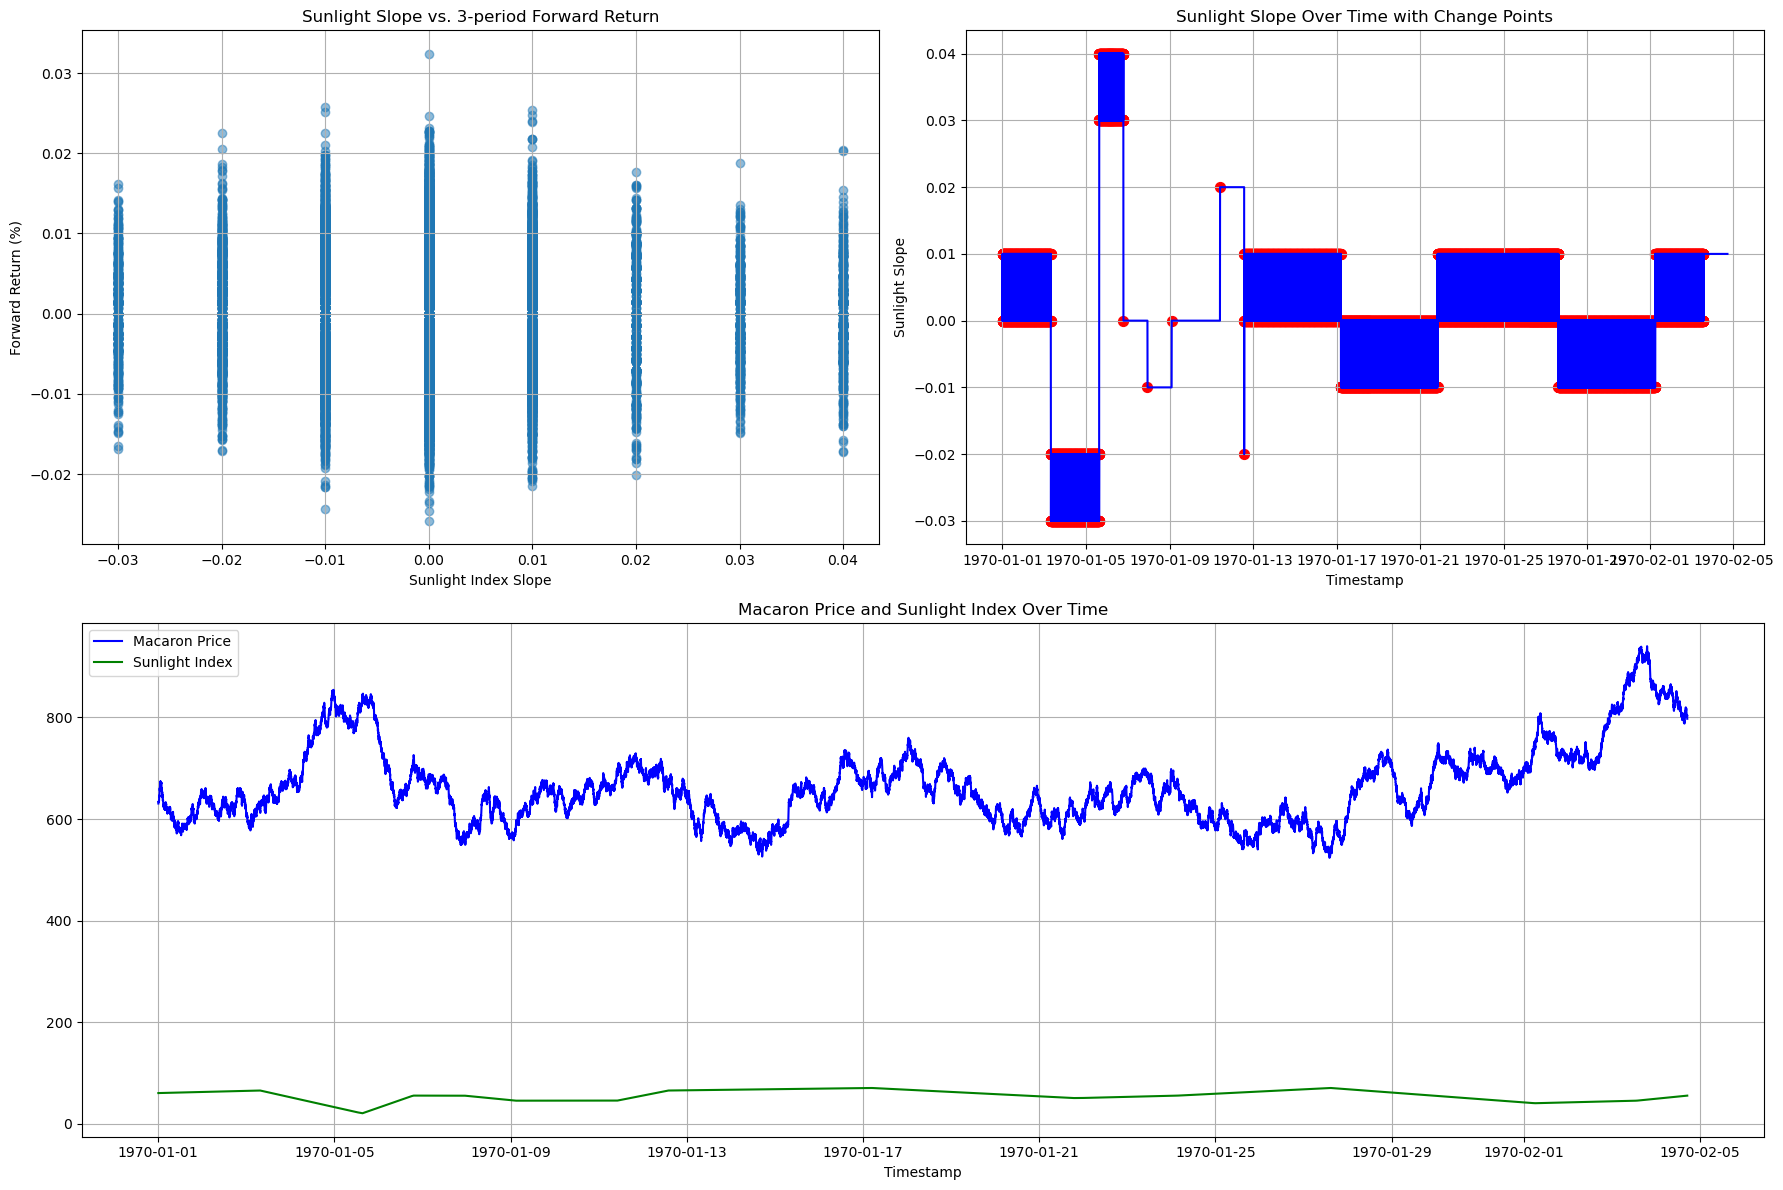


===== Suggested Strategy Implementation =====

# Add to MacaronsStrategy class
self.sunlight_history = deque(maxlen=5)  # Store recent sunlight index values
self.slope_history = deque(maxlen=3)     # Store recent slope values
self.negative_slope_threshold = -0.01
self.positive_slope_threshold = 0.01
self.fair_value_range = (550, 700)  # Estimated fair value range for macarons

def calculate_sunlight_slope(self):
    """Calculate the current slope of the sunlight index"""
    if len(self.sunlight_history) < 2:
        return None
    
    # Calculate simple two-point slope
    y1 = self.sunlight_history[-2]
    y2 = self.sunlight_history[-1]
    return y2 - y1  # Assuming timestamps are evenly spaced

def detect_slope_change(self):
    """Detect if there was a significant change in slope"""
    if len(self.slope_history) < 2:
        return False, 0
    
    slope_change = self.slope_history[-1] - self.slope_history[-2]
    is_significant = abs(slope_change) > 0.001  # Adjust threshold

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming macaron_data is already prepared with timestamps, prices, etc.

# 1. First, make sure your timestamps are properly formatted
# If they're numeric, convert them to datetime or ensure proper scaling
if not pd.api.types.is_datetime64_any_dtype(macaron_data['timestamp']):
    # If using numeric timestamps, try this:
    print("Original timestamp range:", macaron_data['timestamp'].min(), "to", macaron_data['timestamp'].max())
    
    # Option 1: If timestamps are actually epoch time (seconds since 1970)
   
    
        # Option 2: If timestamps are just sequence numbers, use them directly
    pass

# 2. Check the actual ranges of your data
print("\nData ranges:")
for col in ['sunlightIndex', 'mid_price', 'forward_return_3']:
    if col in macaron_data.columns:
        print(f"{col}: {macaron_data[col].min()} to {macaron_data[col].max()}")

# 3. Calculate slope with proper data validation
window = 2  # Minimum window to calculate slope

# Calculate consecutive point-to-point slopes
macaron_data['sunlight_slope'] = np.nan
for i in range(window, len(macaron_data)):
    # Use simple two-point slope for cleaner calculation
    y1 = macaron_data['sunlightIndex'].iloc[i-window]
    y2 = macaron_data['sunlightIndex'].iloc[i-1]
    x_diff = 1  # Assuming uniform time steps
    
    if x_diff > 0:  # Prevent division by zero
        slope = (y2 - y1) / x_diff
        macaron_data.loc[macaron_data.index[i-1], 'sunlight_slope'] = slope

# Print slope statistics
print("\nSlope statistics:")
print(macaron_data['sunlight_slope'].describe())

# Calculate when slope changes
macaron_data['slope_change'] = macaron_data['sunlight_slope'].diff()
# Adjust threshold based on actual slope values
slope_change_threshold = macaron_data['slope_change'].abs().mean() * 2
print(f"\nUsing slope change threshold: {slope_change_threshold}")
macaron_data['significant_slope_change'] = np.abs(macaron_data['slope_change']) > slope_change_threshold

# Clean data and print data count
macaron_data_clean = macaron_data.dropna(subset=['sunlight_slope', 'forward_return_3'])
print(f"\nData points after cleaning: {len(macaron_data_clean)}")

# 4. Plot with improved formatting and explicit data point check
plt.figure(figsize=(18, 12))

# Only plot if we have data
if len(macaron_data_clean) > 0:
    # Slope vs. Forward Returns - Scatter Plot
    plt.subplot(2, 2, 1)
    plt.scatter(macaron_data_clean['sunlight_slope'], macaron_data_clean['forward_return_3'], alpha=0.5)
    plt.title('Sunlight Slope vs. 3-period Forward Return')
    plt.xlabel('Sunlight Index Slope')
    plt.ylabel('Forward Return (%)')
    plt.grid(True)
    
    # Print min/max to ensure data is visible on the plot
    print(f"\nPlot 1 ranges - X: {macaron_data_clean['sunlight_slope'].min()} to {macaron_data_clean['sunlight_slope'].max()}")
    print(f"Plot 1 ranges - Y: {macaron_data_clean['forward_return_3'].min()} to {macaron_data_clean['forward_return_3'].max()}")
    
    # Slope over time
    plt.subplot(2, 2, 2)
    plt.plot(macaron_data_clean['timestamp'], macaron_data_clean['sunlight_slope'], 'b-')
    if macaron_data_clean['significant_slope_change'].any():
        plt.scatter(
            macaron_data_clean.loc[macaron_data_clean['significant_slope_change'], 'timestamp'],
            macaron_data_clean.loc[macaron_data_clean['significant_slope_change'], 'sunlight_slope'],
            color='r', marker='o', s=50
        )
    plt.title('Sunlight Slope Over Time with Change Points')
    plt.xlabel('Timestamp')
    plt.ylabel('Sunlight Slope')
    plt.grid(True)
    
    # Composite plot
    plt.subplot(2, 1, 2)
    plt.plot(macaron_data_clean['timestamp'], macaron_data_clean['mid_price'], 'b-', label='Macaron Price')
    plt.plot(macaron_data_clean['timestamp'], macaron_data_clean['sunlightIndex'], 'g-', label='Sunlight Index')
    plt.title('Macaron Price and Sunlight Index Over Time')
    plt.xlabel('Timestamp')
    plt.legend()
    plt.grid(True)
else:
    print("No clean data available for plotting!")

plt.tight_layout()
plt.show()

# 8. Trading strategy implementation suggestion
print("\n===== Suggested Strategy Implementation =====")
print(f"""
# Add to MacaronsStrategy class
self.sunlight_history = deque(maxlen=5)  # Store recent sunlight index values
self.slope_history = deque(maxlen=3)     # Store recent slope values
self.negative_slope_threshold = {negative_slope_threshold}
self.positive_slope_threshold = {positive_slope_threshold}
self.fair_value_range = (550, 700)  # Estimated fair value range for macarons

def calculate_sunlight_slope(self):
    \"\"\"Calculate the current slope of the sunlight index\"\"\"
    if len(self.sunlight_history) < 2:
        return None
    
    # Calculate simple two-point slope
    y1 = self.sunlight_history[-2]
    y2 = self.sunlight_history[-1]
    return y2 - y1  # Assuming timestamps are evenly spaced

def detect_slope_change(self):
    \"\"\"Detect if there was a significant change in slope\"\"\"
    if len(self.slope_history) < 2:
        return False, 0
    
    slope_change = self.slope_history[-1] - self.slope_history[-2]
    is_significant = abs(slope_change) > 0.001  # Adjust threshold as needed
    return is_significant, slope_change

def update_state(self, state: TradingState) -> None:
    # Update existing state
    # ...existing code...
    
    # Update sunlight history and slopes
    if 'sunlightIndex' in state.observations.plainValueObservations:
        sunlight_index = state.observations.plainValueObservations['sunlightIndex']
        self.sunlight_history.append(sunlight_index)
        
        # Calculate and store current slope
        current_slope = self.calculate_sunlight_slope()
        if current_slope is not None:
            self.slope_history.append(current_slope)
        
def act(self, state: TradingState) -> None:
    # ...existing code...
    
    # Get current slope
    current_slope = self.calculate_sunlight_slope()
    if current_slope is not None:
        logger.print(f"T={{state.timestamp}}: Current sunlight slope: {{current_slope:.4f}}")
        
        # Check for slope change
        slope_change_detected, slope_change = self.detect_slope_change()
        if slope_change_detected:
            if slope_change > 0:
                logger.print(f"T={{state.timestamp}}: SIGNIFICANT SLOPE INCREASE DETECTED!")
            else:
                logger.print(f"T={{state.timestamp}}: SIGNIFICANT SLOPE DECREASE DETECTED!")
        
        # Adjust strategy based on slope conditions
        current_mid = (best_bid + best_ask) / 2
        
        # Case 1: Steep Negative Slope - Prices likely to fall
        if current_slope < self.negative_slope_threshold:
            logger.print(f"T={{state.timestamp}}: STEEP NEGATIVE SLOPE: {{current_slope:.4f}}")
            # Increase sell aggression, reduce buy aggression
            self.sell_threshold = 0.5  # More aggressive selling
            self.buy_threshold = 3.0   # More conservative buying
            
        # Case 2: Slope Trend Change - React to inflection points
        elif slope_change_detected:
            if slope_change > 0:  # Slope becoming more positive
                # If price is below fair value, buy more aggressively
                if current_mid < self.fair_value_range[0]:
                    logger.print(f"T={{state.timestamp}}: POSITIVE SLOPE CHANGE + BELOW FAIR VALUE")
                    self.buy_threshold = 0.5   # More aggressive buying
                    self.sell_threshold = 3.0  # More conservative selling
                    
                # If price is above fair value, expect reversion
                elif current_mid > self.fair_value_range[1]:
                    logger.print(f"T={{state.timestamp}}: POSITIVE SLOPE CHANGE + ABOVE FAIR VALUE")
                    self.sell_threshold = 0.5  # More aggressive selling - expect reversion
                    self.buy_threshold = 2.0   # Moderately conservative buying
                    
            else:  # Slope becoming more negative
                logger.print(f"T={{state.timestamp}}: NEGATIVE SLOPE CHANGE")
                # Increase sell aggression regardless of price level
                self.sell_threshold = 0.5  # More aggressive selling
                self.buy_threshold = 3.0   # More conservative buying
        
        # Case 3: Steep Positive Slope - Tendency to revert to fair value
        elif current_slope > self.positive_slope_threshold:
            logger.print(f"T={{state.timestamp}}: STEEP POSITIVE SLOPE: {{current_slope:.4f}}")
            
            # If currently below fair value, buy aggressively
            if current_mid < self.fair_value_range[0]:
                logger.print(f"T={{state.timestamp}}: STEEP POSITIVE SLOPE + BELOW FAIR VALUE")
                self.buy_threshold = 0.5   # More aggressive buying
                self.sell_threshold = 3.0  # More conservative selling
                
            # If currently above fair value, sell aggressively  
            elif current_mid > self.fair_value_range[1]:
                logger.print(f"T={{state.timestamp}}: STEEP POSITIVE SLOPE + ABOVE FAIR VALUE")
                self.sell_threshold = 0.5  # More aggressive selling
                self.buy_threshold = 3.0   # More conservative buying
        else:
            # Normal conditions
            self.buy_threshold = 1.0
            self.sell_threshold = 1.0
            
    # Continue with existing trading logic
    # ...
""")